In [16]:
import random
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from data_preparation import get_cifar10_datasets, get_dataloader
from train import train_model

# Functions

In [ ]:
def plot_triplet_images(image_label_tuple, index_to_class_mapping):
    """
    Plots a row of 3 CIFAR-10 images with labels.

    Args:
        image_label_tuple (tuple): A tuple of (images, labels) where:
            - images is a list or tensor of 3 images
            - labels is a list or tensor of 3 corresponding labels
        index_to_class_mapping (dict): Mapping from class index to class name
    """
    images, labels = image_label_tuple
    assert len(images) == 3

    label_title = ['anchor', 'positive', 'negative']
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    for i in range(3):
        img, label = images[i], labels
        if i == 2:
            display_label = 'other'
        else:
            display_label = index_to_class_mapping[label]

        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
            if img.shape[0] == 3:  # (C, H, W)
                img = img.permute(1, 2, 0)  # to (H, W, C)
        
        axs[i].imshow(img)
        axs[i].set_title(label_title[i] + ': ' + display_label, fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [14]:
def show_image(image_tensor, title=None):
    assert isinstance(image_tensor, torch.Tensor), "Input must be a torch.Tensor"
    assert image_tensor.shape == (3, 32, 32), "Image must be of shape (3, 32, 32)"

    # Move to CPU, detach, and convert to numpy
    img = image_tensor.detach().cpu()
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # Rescale from normalized range [-1, 1] or other to [0, 1] if needed
    img = (img - img.min()) / (img.max() - img.min())

    # Plot the image
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Dataset

In [6]:
CLASS_INDEX = [0, 1, 2, 3]
CLASS_LABEL = ['cat', 'dog', 'ship', 'truck']
LABEL_MAP = {original_label: new_label for new_label, original_label in enumerate(CLASS_INDEX)}
INDEX_TO_CLASS = {i: j for i, j in zip(CLASS_INDEX, CLASS_LABEL)}

In [7]:
train_dataset, test_dataset = get_cifar10_datasets(data_dir='./data')
train_loader, test_loader = get_dataloader(train_dataset, test_dataset)

Filtering and remapping base training dataset...
Dataset filtered. New number of samples: 20000
Filtering and remapping base testing dataset...
Dataset filtered. New number of samples: 4000
Triplet Dataset created with 20000 samples (based on base dataset size).
Classes found in dataset: [0, 1, 2, 3]
Filtered CIFAR-10 Triplet train loader and standard test loader created with 4 workers.


In [ ]:
plot_triplet_images(train_dataset[random.randint(0, 20000)], INDEX_TO_CLASS)

# Training

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=10,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=10,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

# Predict

In [3]:
from predict import load_trained_model, predict_image_class

In [4]:
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [5]:
model = load_trained_model('./output/cnn_4cls_128dim_model.pth', 'cnn', 128, 4, DEVICE)

Model loaded successfully from ./output/cnn_4cls_128dim_model.pth


In [20]:
test_dataset[1][1]

2

In [19]:
F.softmax(model(test_dataset[1][0].to(DEVICE)))

/var/folders/w5/w4nlx9qs6d3fn7zkg65ps2bh0000gn/T/ipykernel_5392/855856324.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(model(test_dataset[1][0].to(DEVICE)))


tensor([[2.8441e-04, 4.2710e-05, 9.9936e-01, 3.1270e-04]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [22]:
model.get_embedding(test_dataset[1][0].to(DEVICE))

tensor([[ 0.6434,  0.9323,  0.4026,  0.0744,  0.3516,  0.4022,  0.0411,  0.2594,
         -0.8487,  0.6498, -0.1127, -0.3098, -0.4078, -0.0682,  0.2459,  0.0418,
         -0.2495, -0.2023,  0.1984,  0.4112, -0.2441,  0.0932,  0.0658,  0.0073,
         -0.3816, -0.3088, -0.1498, -0.6386, -0.1389, -0.2496, -0.2576, -0.4026,
         -0.0013, -0.4772, -0.2112, -0.2154, -0.4472, -0.5735, -0.0720, -0.2778,
         -0.0609,  0.2521,  0.2349, -0.1334,  0.3723, -0.1490,  0.4521, -0.3317,
         -0.6547,  0.5991,  0.2942, -0.2258, -0.7593,  0.6373,  0.2341,  0.1778,
          0.0221,  0.0216, -0.0937, -0.2429,  0.0681, -0.3883,  0.3237,  0.4536,
         -0.5561, -0.4577,  0.1926,  0.1559,  0.1452,  0.0410, -0.1660, -0.1513,
          0.0107,  0.7070, -0.7750, -0.2765,  0.6864,  0.0429,  0.0619,  0.1700,
         -0.5426,  0.1706,  0.4701, -0.5022,  0.4120, -0.2666,  0.5633,  0.1182,
          0.1351, -0.4838, -0.1309,  0.6244, -0.6927, -0.4140,  0.2680, -0.3124,
          0.4971, -0.3563, -

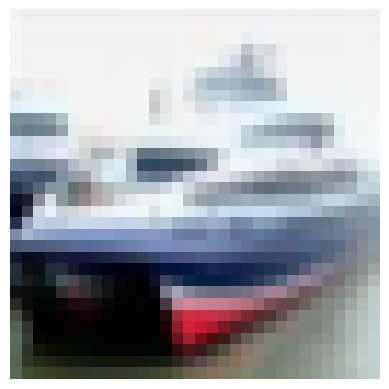

In [18]:
show_image(test_dataset[1][0])